In [17]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

# Goal

To create simple model which predicts a users rating for a book given the amount of reviews on it, the price in dollars, year released and genre.



# Data exploration

In [2]:
dataset_path = '/kaggle/input/amazon-top-50-bestselling-books-2009-2019/bestsellers with categories.csv'
amazon_dataset = pd.read_csv(dataset_path)
amazon_dataset.head()

,Name,Author,User Rating,Reviews,Price,Year,Genre
0,10-Day Green Smoothie Cleanse,JJ Smith,4.7,17350,8,2016,Non Fiction
1,11/22/63: A Novel,Stephen King,4.6,2052,22,2011,Fiction
2,12 Rules for Life: An Antidote to Chaos,Jordan B. Peterson,4.7,18979,15,2018,Non Fiction
3,1984 (Signet Classics),George Orwell,4.7,21424,6,2017,Fiction
4,"5,000 Awesome Facts (About Everything!) (Natio...",National Geographic Kids,4.8,7665,12,2019,Non Fiction


In [3]:
amazon_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550 entries, 0 to 549
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Name         550 non-null    object 
 1   Author       550 non-null    object 
 2   User Rating  550 non-null    float64
 3   Reviews      550 non-null    int64  
 4   Price        550 non-null    int64  
 5   Year         550 non-null    int64  
 6   Genre        550 non-null    object 
dtypes: float64(1), int64(3), object(3)
memory usage: 30.2+ KB


array([[<Axes: title={'center': 'User Rating'}>,
        <Axes: title={'center': 'Reviews'}>],
       [<Axes: title={'center': 'Price'}>,
        <Axes: title={'center': 'Year'}>]], dtype=object)

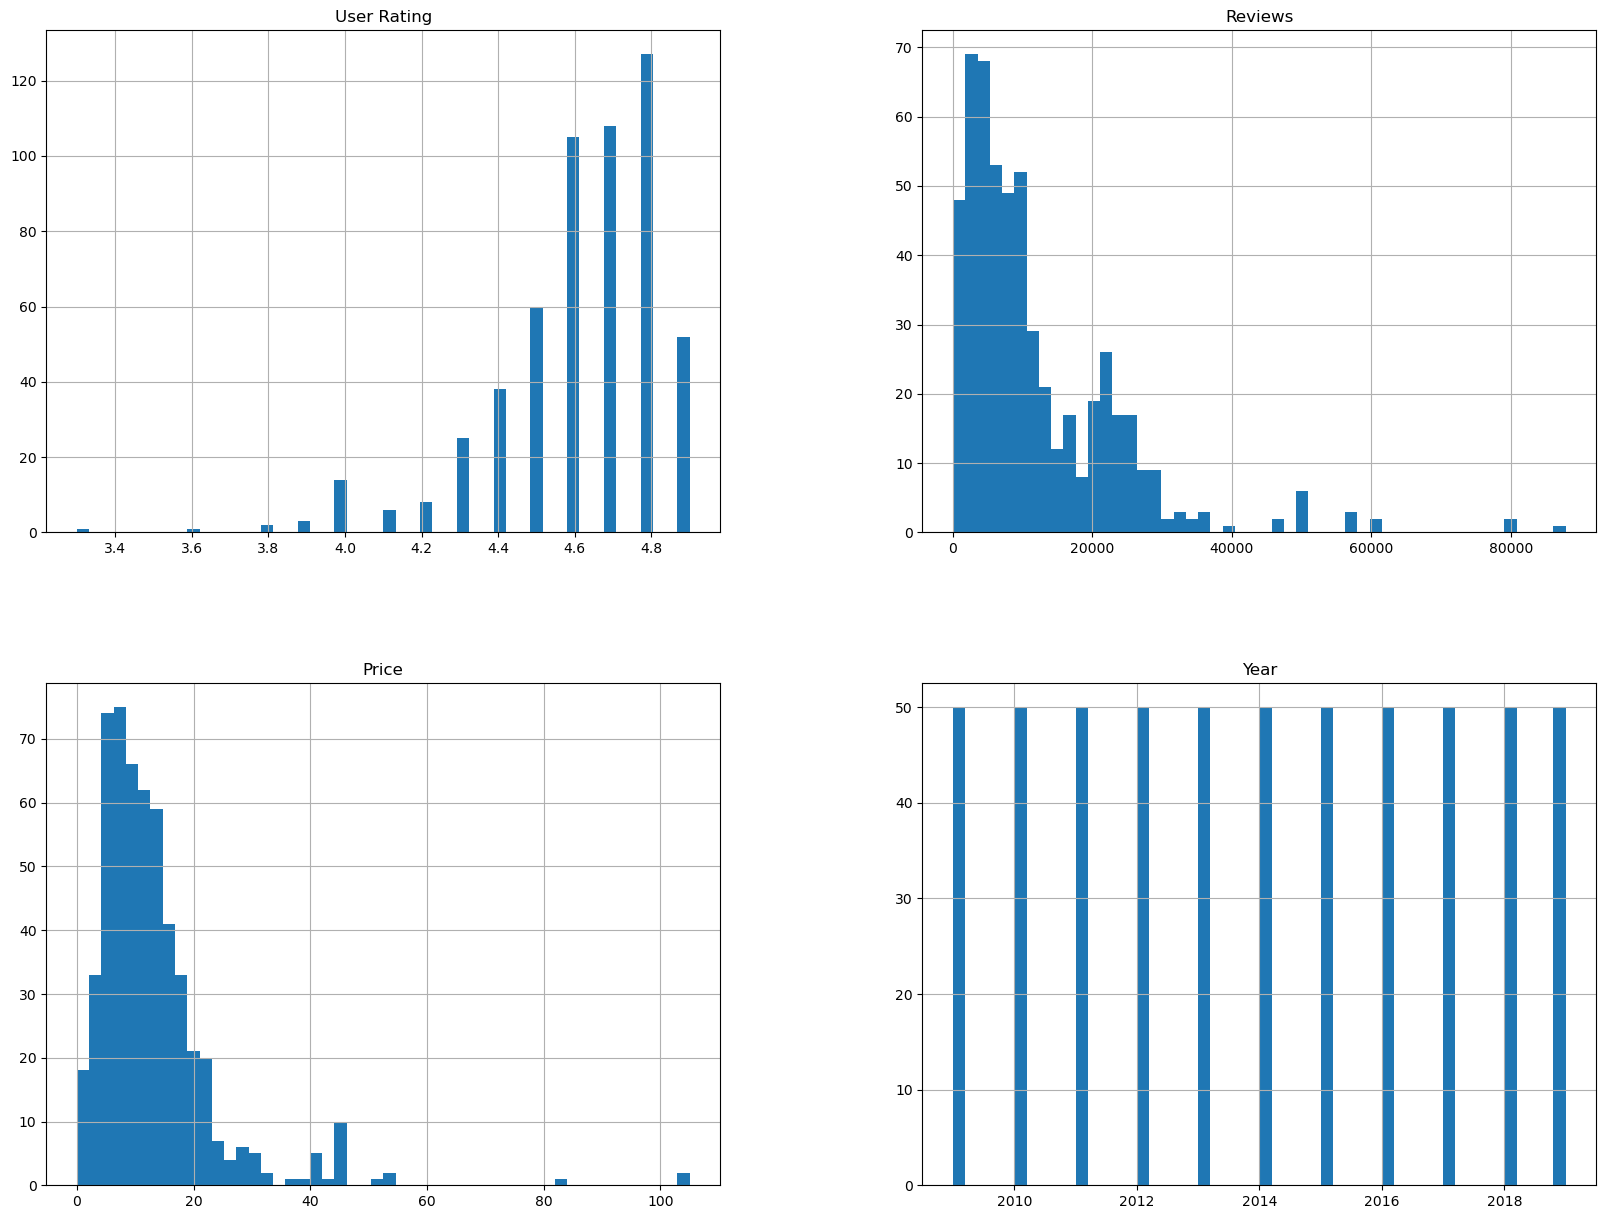

In [4]:
amazon_dataset.hist(bins=50, figsize=(20,15))

User rating, price, and reviews all seem to follow an exponential distribution, with far outliers on the tails. 
Those will all have to be standardized, but for fun lets look at the extreem ends of ditributions first. 



In [5]:
amazon_dataset.describe()

,User Rating,Reviews,Price,Year
count,550.000000,550.000000,550.000000,550.000000
mean,4.618364,11953.281818,13.100000,2014.000000
std,0.226980,11731.132017,10.842262,3.165156
min,3.300000,37.000000,0.000000,2009.000000
25%,4.500000,4058.000000,7.000000,2011.000000
50%,4.700000,8580.000000,11.000000,2014.000000
75%,4.800000,17253.250000,16.000000,2017.000000
max,4.900000,87841.000000,105.000000,2019.000000


The highest amount of reviews a book got in this dataset was 87841, I wonder what book could have lead to everybody discussing it so much.

In [6]:
amazon_dataset.loc[amazon_dataset["Reviews"] == 87841]

,Name,Author,User Rating,Reviews,Price,Year,Genre
534,Where the Crawdads Sing,Delia Owens,4.8,87841,15,2019,Fiction


Somebody more in the fiction space might have guessed this book, doing a quick google searched revealed it used to be the Amazon top best seller and is now getting a movie, it's very popular.

Whats the most expensive book in the list?

In [7]:
amazon_dataset.loc[amazon_dataset["Price"] == 105]

,Name,Author,User Rating,Reviews,Price,Year,Genre
69,Diagnostic and Statistical Manual of Mental Di...,American Psychiatric Association,4.5,6679,105,2013,Non Fiction
70,Diagnostic and Statistical Manual of Mental Di...,American Psychiatric Association,4.5,6679,105,2014,Non Fiction


The DSM, a manual for psychiatric testing, no wonder it's so expsenive.

In [8]:
amazon_dataset.loc[amazon_dataset["Price"] == 0]

,Name,Author,User Rating,Reviews,Price,Year,Genre
42,"Cabin Fever (Diary of a Wimpy Kid, Book 6)",Jeff Kinney,4.8,4505,0,2011,Fiction
71,"Diary of a Wimpy Kid: Hard Luck, Book 8",Jeff Kinney,4.8,6812,0,2013,Fiction
116,Frozen (Little Golden Book),RH Disney,4.7,3642,0,2014,Fiction
193,JOURNEY TO THE ICE P,RH Disney,4.6,978,0,2014,Fiction
219,Little Blue Truck,Alice Schertle,4.9,1884,0,2014,Fiction
358,The Constitution of the United States,Delegates of the Constitutional,4.8,2774,0,2016,Non Fiction
381,The Getaway,Jeff Kinney,4.8,5836,0,2017,Fiction
461,The Short Second Life of Bree Tanner: An Eclip...,Stephenie Meyer,4.6,2122,0,2010,Fiction
505,To Kill a Mockingbird,Harper Lee,4.8,26234,0,2013,Fiction
506,To Kill a Mockingbird,Harper Lee,4.8,26234,0,2014,Fiction


Looking at the entrys where the price is zero there is a clear problem. It looks like there are not only some books with price erronously entered as zero cost but also duplicates of books in the dataset, that will need to be taken care of, but for now I'm just going to keep exploring the data.

In [9]:
amazon_dataset.loc[amazon_dataset["User Rating"] == 3.3]

,Name,Author,User Rating,Reviews,Price,Year,Genre
353,The Casual Vacancy,J.K. Rowling,3.3,9372,12,2012,Fiction


In [10]:
amazon_dataset.loc[amazon_dataset["User Rating"] == 4.9]

,Name,Author,User Rating,Reviews,Price,Year,Genre
40,"Brown Bear, Brown Bear, What Do You See?",Bill Martin Jr.,4.9,14344,5,2017,Fiction
41,"Brown Bear, Brown Bear, What Do You See?",Bill Martin Jr.,4.9,14344,5,2019,Fiction
81,Dog Man and Cat Kid: From the Creator of Capta...,Dav Pilkey,4.9,5062,6,2018,Fiction
82,Dog Man: A Tale of Two Kitties: From the Creat...,Dav Pilkey,4.9,4786,8,2017,Fiction
83,Dog Man: Brawl of the Wild: From the Creator o...,Dav Pilkey,4.9,7235,4,2018,Fiction
84,Dog Man: Brawl of the Wild: From the Creator o...,Dav Pilkey,4.9,7235,4,2019,Fiction
85,Dog Man: Fetch-22: From the Creator of Captain...,Dav Pilkey,4.9,12619,8,2019,Fiction
86,Dog Man: For Whom the Ball Rolls: From the Cre...,Dav Pilkey,4.9,9089,8,2019,Fiction
87,Dog Man: Lord of the Fleas: From the Creator o...,Dav Pilkey,4.9,5470,6,2018,Fiction
146,"Goodnight, Goodnight Construction Site (Hardco...",Sherri Duskey Rinker,4.9,7038,7,2012,Fiction


Other than the interesting fact of J.K. Rowling being in the best rated in worst rated spots, everything is normal here.

It also seems the curator of the dataset made sure to pick an equal amount of books from each year. Lets make sure with one example.

In [11]:
year2019 = amazon_dataset.loc[amazon_dataset["Year"] == 2019]

np.round(year2019.shape[0] / 550, decimals=2) #books out in 2019 as a total amount of dataset


0.09

That doesn't look right, ideally that number would be .1, since we have 10 years of books and each year should get 10% representation in the dataset to be equal. But it is probably just a rounding error.

To be totally sure let's check that every year has equal weighting.

In [12]:
def yearRatios(dataset):
    """
    gets the years out of a dataset and returns the ratio of that years entries 
    
    #Parameters:
    #    dataset (Pandas Dataframe): a dataset to take the years from

    #Returns:
    #    dictionary (dict): of both the year and the ratio of that year's contibution to all dataset values   

    """
    years_dict = {}
    year_series = dataset['Year']
    total_instances = year_series.shape[0]
    years = np.sort(year_series.unique())
    for i in range(len(years)):
        year = years[i]
        total_year_amount = dataset.loc[dataset["Year"] == year]
        year_count = total_year_amount.shape[0]
        year_ratio = np.round(year_count / total_instances, decimals=2)
        years_dict[year] = year_ratio
    return years_dict
        
    
yearRatios(amazon_dataset)

{2009: 0.09,
 2010: 0.09,
 2011: 0.09,
 2012: 0.09,
 2013: 0.09,
 2014: 0.09,
 2015: 0.09,
 2016: 0.09,
 2017: 0.09,
 2018: 0.09,
 2019: 0.09}

Thankfully it looks like all years are given an equal weight, so nothing to worry about for stratification there. But lets see if stratification is needed for the amount of fiction books vs. non-fiction books. 

In [13]:
Fiction_fraction = amazon_dataset.loc[amazon_dataset["Genre"] == "Fiction"]

np.round(Fiction_fraction.shape[0] / 550, decimals=2) * 100

44.0

Seems like there is a bias in favor of non-fiction books in the dataset, so the training and test sets will need to be stratified based on that.

# 2. Data cleaning and transformation

First lets take out all books with a zero price, sadly my modeling assumption is I don't think Amazon is offering free products.

In [14]:
def No_zero_price(dataset):
    zero_indexes = dataset.loc[dataset["Price"] == 0].index
    return dataset.drop(zero_indexes)

amazon_no_zeros = No_zero_price(amazon_dataset)

amazon_no_zeros

,Name,Author,User Rating,Reviews,Price,Year,Genre
0,10-Day Green Smoothie Cleanse,JJ Smith,4.7,17350,8,2016,Non Fiction
1,11/22/63: A Novel,Stephen King,4.6,2052,22,2011,Fiction
2,12 Rules for Life: An Antidote to Chaos,Jordan B. Peterson,4.7,18979,15,2018,Non Fiction
3,1984 (Signet Classics),George Orwell,4.7,21424,6,2017,Fiction
4,"5,000 Awesome Facts (About Everything!) (Natio...",National Geographic Kids,4.8,7665,12,2019,Non Fiction
...,...,...,...,...,...,...,...
545,Wrecking Ball (Diary of a Wimpy Kid Book 14),Jeff Kinney,4.9,9413,8,2019,Fiction
546,You Are a Badass: How to Stop Doubting Your Gr...,Jen Sincero,4.7,14331,8,2016,Non Fiction
547,You Are a Badass: How to Stop Doubting Your Gr...,Jen Sincero,4.7,14331,8,2017,Non Fiction
548,You Are a Badass: How to Stop Doubting Your Gr...,Jen Sincero,4.7,14331,8,2018,Non Fiction


Now dropping duplicate rows based on the book name. It looks like books were entered mutiple times different years. That might mess up model predictions.

In [15]:
def drop_name_dupes(dataframe):
    """
    finds the rows where the name for the book has been duplicated and drops them from the dataset
    
    #Parameters:
    #    dataset (Pandas Dataframe): a dataset to take the names from

    #Returns:
    #    Pandas Dataframe: A new dataframe with the duplicate rows removed.
    
    """
    df = dataframe
    return df[pd.DataFrame.duplicated(df,subset=["Name"]) == False]
    
amazon_nodupes_nozero = drop_name_dupes(amazon_no_zeros)

amazon_nodupes_nozero.shape[0]

343

Ouch, only 343 viable books to work with now, but it's what we got. Lets standardize the data.

In [33]:
def standardize_numerics(dataset):
    """
    Pulls out all the numerical columns, standardizes them, then returns a new dataframe with the values
    standardized.
    
    #Parameters:
    #    dataset (Pandas Dataframe): a dataset to take the years from

    #Returns:
    #    Pandas Dataframe: A new dataframe with the numerical values standardized.
    
    """
    df = dataset.copy()
    numerical_columns = df.select_dtypes(include=np.number).columns.tolist()
    sc = StandardScaler()
    temp_dict = {}
    for i in numerical_columns:
        name = i
        num_array = pd.Series(df[name]).to_numpy().reshape(-1,1)
        scaled_array = sc.fit_transform(num_array).ravel()
        temp_dict[i] = list(scaled_array)
    std_num_frame = pd.DataFrame(temp_dict, columns=numerical_columns)
    std_num_frame_id = std_num_frame.reset_index()
    og_dropped = df.drop(labels=numerical_columns, axis=1)
    og_dropped_id = og_dropped.reset_index()
    combined = pd.concat([og_dropped_id,std_num_frame_id], axis= 1, join='inner')
    combined_right_shape = combined.drop('index',axis=1)
    return combined_right_shape

    
amazon_standard = standardize_numerics(amazon_nodupes_nozero)

amazon_standard

,Name,Author,Genre,User Rating,Reviews,Price,Year
0,10-Day Green Smoothie Cleanse,JJ Smith,Non Fiction,0.415363,0.677145,-0.544066,0.745495
1,11/22/63: A Novel,Stephen King,Fiction,-0.024358,-0.721770,0.865866,-0.763978
2,12 Rules for Life: An Antidote to Chaos,Jordan B. Peterson,Non Fiction,0.415363,0.826107,0.160900,1.349284
3,1984 (Signet Classics),George Orwell,Fiction,0.415363,1.049689,-0.745484,1.047389
4,"5,000 Awesome Facts (About Everything!) (Natio...",National Geographic Kids,Non Fiction,0.855083,-0.208493,-0.141228,1.651178
...,...,...,...,...,...,...,...
338,Winter of the World: Book Two of the Century T...,Ken Follett,Fiction,-0.464078,0.074527,0.160900,-0.462083
339,Women Food and God: An Unexpected Path to Almo...,Geneen Roth,Non Fiction,-1.783240,-0.790353,-0.241937,-1.065872
340,Wonder,R. J. Palacio,Fiction,0.855083,1.068069,-0.443356,-0.160189
341,Wrecking Ball (Diary of a Wimpy Kid Book 14),Jeff Kinney,Fiction,1.294804,-0.048649,-0.544066,1.651178


array([[<Axes: title={'center': 'User Rating'}>,
        <Axes: title={'center': 'Reviews'}>],
       [<Axes: title={'center': 'Price'}>,
        <Axes: title={'center': 'Year'}>]], dtype=object)

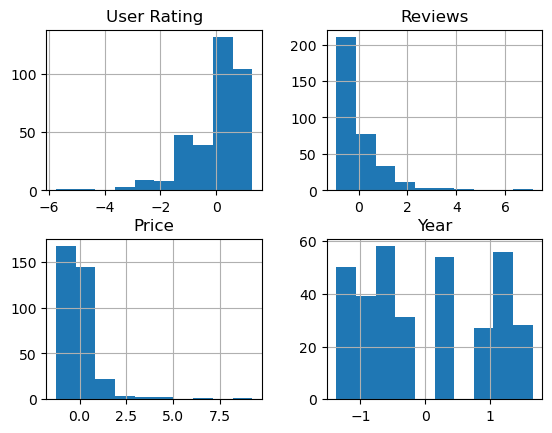

In [34]:
amazon_standard.hist()

In [45]:
amazon_standard.describe()

,User Rating,Reviews,Price,Year
count,3.430000e+02,3.430000e+02,3.430000e+02,3.430000e+02
mean,2.894996e-15,6.473604e-17,7.250436e-17,-3.222301e-14
std,1.001461e+00,1.001461e+00,1.001461e+00,1.001461e+00
min,-5.740724e+00,-9.060302e-01,-1.249032e+00,-1.367767e+00
25%,-4.640782e-01,-5.908675e-01,-5.440657e-01,-1.065872e+00
50%,-2.435769e-02,-3.058814e-01,-1.412281e-01,-1.601889e-01
75%,8.550832e-01,1.555465e-01,2.616096e-01,7.454946e-01
max,1.294804e+00,7.123143e+00,9.224747e+00,1.651178e+00


Nice to have that done, should help our ML algorithms converge faster.

In [ ]:
hot_enc = OneHotEncoder()
